## Autoencoder Model for noise supression

### Standard imports

In [23]:
import tensorflow as tf            # tensorflow importing
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np                 # numpy package importing
import matplotlib.pyplot as plt    # matplotlib package importing
import IPython.display
import glob
from tqdm.notebook import tqdm     # a library used to visualize progress as a dynamic filling bar 
import librosa.display              # a python package used to do analysis on audio data and visualize it
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input

### Loading the audio data

In [2]:
# Loading the whole audios paths into the lists 
clean_sounds = glob.glob('./CleanData/*')
noisy_sounds = glob.glob('./NoisyData/*')

In [3]:
type(clean_sounds)

list

In [4]:
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    clean_sounds_list = tf.concat((clean_sounds_list,so),0)

  0%|          | 0/11571 [00:00<?, ?it/s]

In [5]:
clean_sounds_list.shape

TensorShape([540938091, 1])

In [6]:
noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

  0%|          | 0/11571 [00:00<?, ?it/s]

In [7]:
noisy_sounds_list.shape

TensorShape([540938091, 1])

In [11]:
clean_sounds_list[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00253296], dtype=float32)>

In [8]:
batching_size = 12000

### Arranging the data

We are trying to arrange the data which is in 1d tensor shape into the 2d tensor with shape $n \times batching\_size$

In [13]:
clean_train_list,noisy_train_list = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
    clean_train_list.append(clean_sounds_list[i:i+batching_size])
    noisy_train_list.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train_list)
noisy_train = tf.stack(noisy_train_list)

  0%|          | 0/45078 [00:00<?, ?it/s]

In [14]:
clean_train.shape

TensorShape([45078, 12000, 1])

In [44]:
len(clean_train)

45078

In [43]:
clean_train[0]

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[-0.00253296],
       [-0.00408936],
       [-0.00482178],
       ...,
       [-0.01043701],
       [ 0.01119995],
       [ 0.02633667]], dtype=float32)>

Now, here, we inturn convert/club the $batching\_size$ dataset into batches of size 64 along with x_train and y_train in one with a datatype of Dataset from tensorflow 

In [15]:
# a function to get dataset with batches of size 64
def get_dataset(x_train,y_train):
    dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
    dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
    return dataset

In [16]:
# splitting the loaded data to train dataset and test dataset 
train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])

In [20]:
len(train_dataset)

625

In [21]:
train_dataset

<BatchDataset shapes: ((64, 12000, 1), (64, 12000, 1)), types: (tf.float32, tf.float32)>

In [56]:
for data in train_dataset:
    print("length of data element in dataset:", len(data))
    print("type of data element in dataset:", type(data))
    print("first element type: ",data[0].shape)
    print("second element type: ", data[1].shape)
    break;

length of data element in dataset: 2
type of data element in dataset: <class 'tuple'>
first element type:  (64, 12000, 1)
second element type:  (64, 12000, 1)


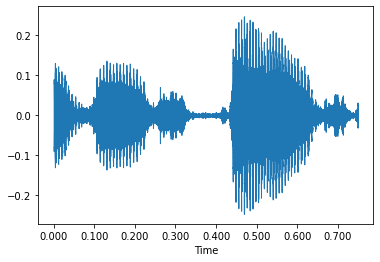

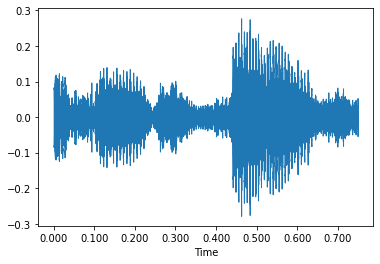

In [42]:
# seeing sample waveform
librosa.display.waveshow(np.squeeze(clean_train[5].numpy(),axis=-1), sr= 16000)
plt.show()
librosa.display.waveshow(np.squeeze(noisy_train[5].numpy(),axis=-1),sr = 16000)
plt.show()

### Building the model

In [9]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

### Visualising the model graphically

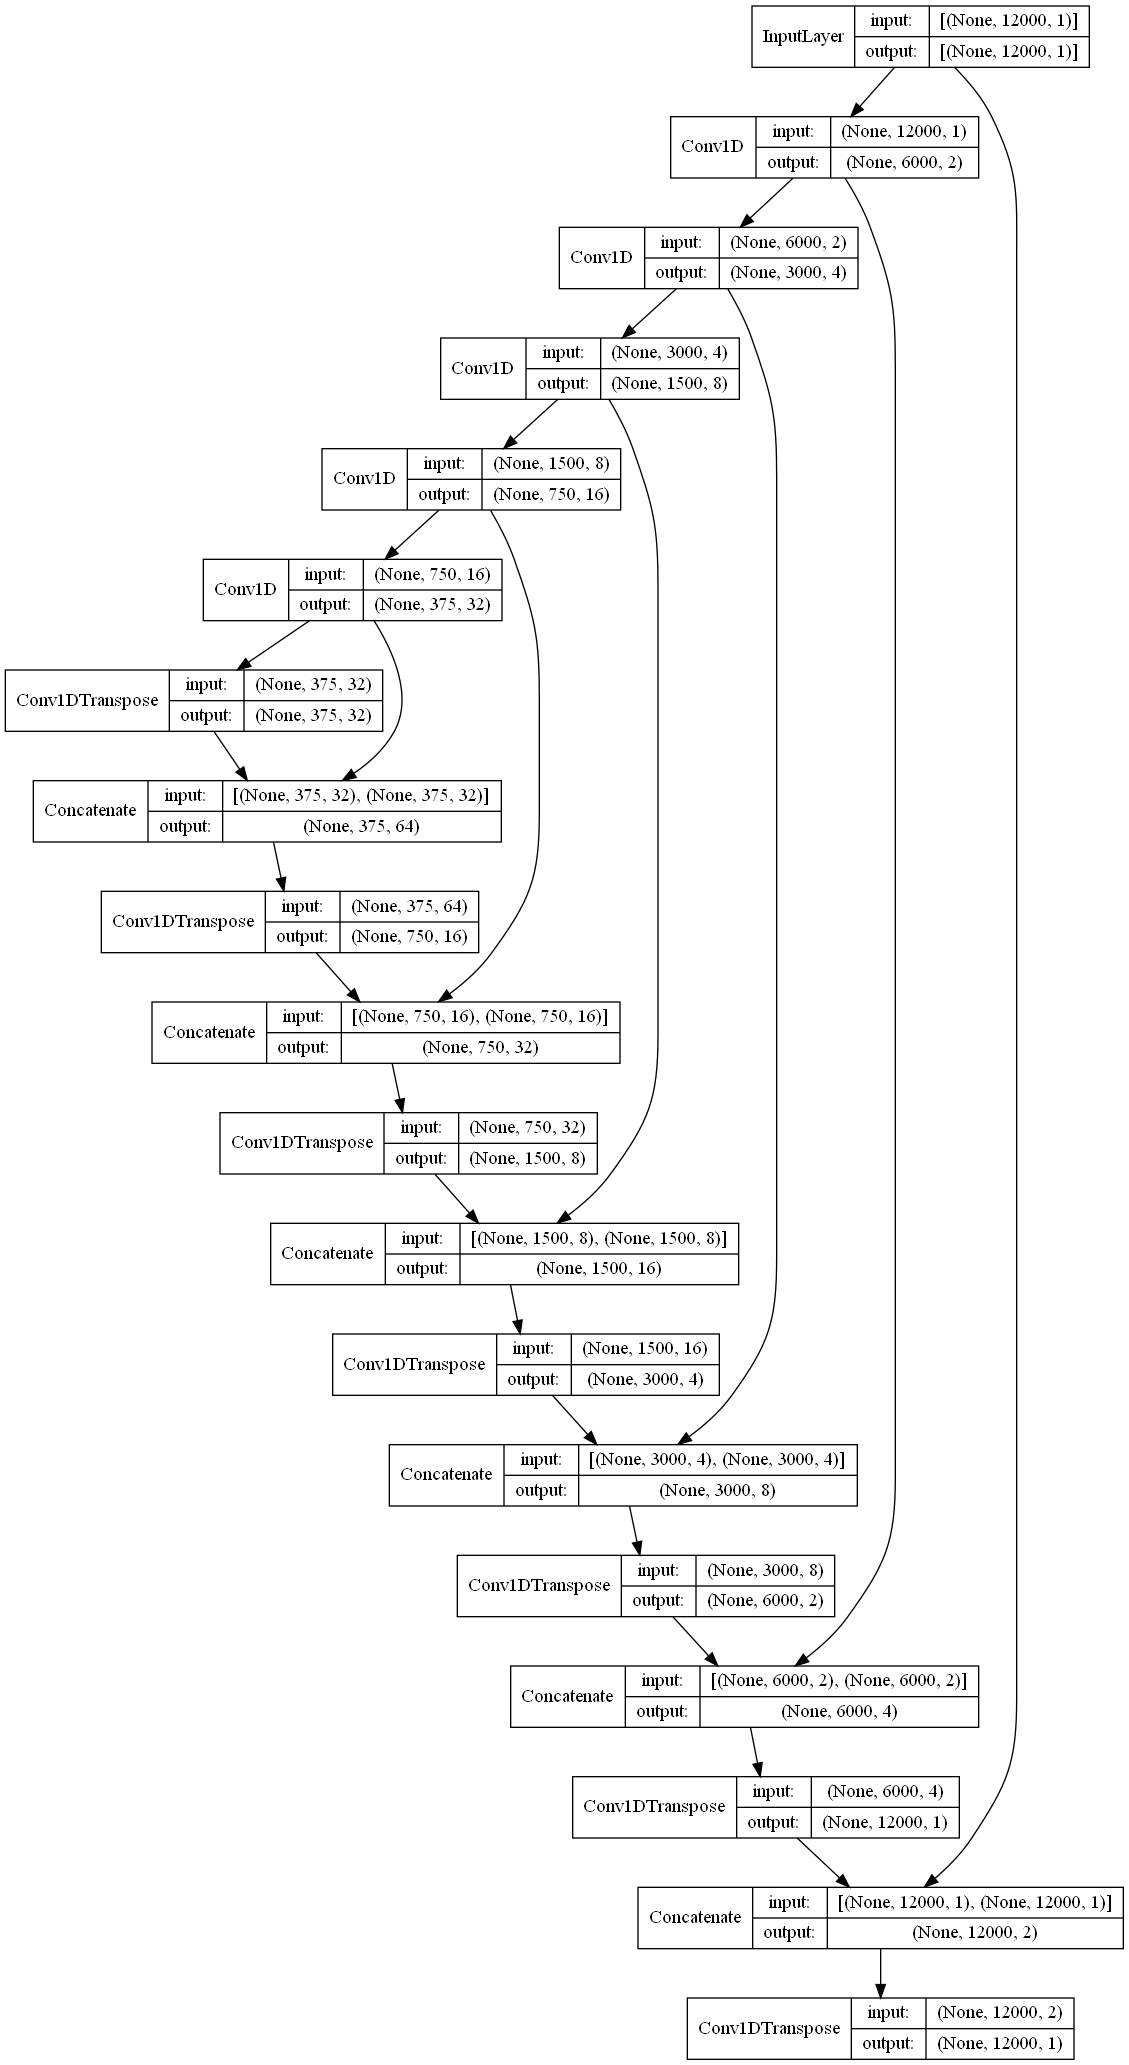

In [30]:
# to see the model visually without showing the names of the layers
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

### Explanation of the model in a nutshell
- What we are essentially doing in this model here is we are trying to find some filters(the 1d convolutions) to reduce the noise.
- The 1d convolutional layer acts as if it's reducing the noise by taking into part the main important things from the data as the conv2d layer in CNNs
- Now, after we go through some set of sufficient filters, we try to go back to the original representation of data via deconvolution from the reduced representation
- While going back from the convoluted size to the original input size, we added the original conv layers output to concatenate because they kind of act as providing some context to the deconvoluting layers so as to obtain better overall results

In [21]:
# compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())

In [31]:
# training the model
history = model.fit(train_dataset,epochs=15)

Epoch 1/15
625/625 [==============================] - 399s 635ms/step - loss: 0.0183
Epoch 2/15
625/625 [==============================] - 568s 910ms/step - loss: 0.0150
Epoch 3/15
625/625 [==============================] - 572s 915ms/step - loss: 0.0144
Epoch 4/15
625/625 [==============================] - 569s 910ms/step - loss: 0.0141
Epoch 5/15
625/625 [==============================] - 566s 906ms/step - loss: 0.0138
Epoch 6/15
625/625 [==============================] - 569s 910ms/step - loss: 0.0137
Epoch 7/15
625/625 [==============================] - 567s 907ms/step - loss: 0.0135
Epoch 8/15
625/625 [==============================] - 567s 906ms/step - loss: 0.0134
Epoch 9/15
625/625 [==============================] - 568s 909ms/step - loss: 0.0133
Epoch 10/15
625/625 [==============================] - 567s 907ms/step - loss: 0.0132
Epoch 11/15
625/625 [==============================] - 568s 908ms/step - loss: 0.0131
Epoch 12/15
625/625 [==============================] - 500s 799

In [38]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[22].numpy()),rate=16000)

In [39]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[22],-1),0))),rate=16000)

### Handling the problem of variable length in audio sequences
- Our model handels specific input shape of size 12000, which is the $batching\_size$ in this case
- To handle the problem of variable length in audio sequences, we can do to pad our splits whenever the size becomes less the   $batching\_size$
- The padding is done by sampling from the rear end of the array
- The model is trained with the padded array. Then in the end, from the filtered audio we consider only the relevant part from the padded audio data

In [32]:
# function to get the audio
def get_audio(path):
    audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
    return audio

In [33]:
# function that handles the process of padding
def inference_preprocess(path):
    audio = get_audio(path)
    audio_len = audio.shape[0]
    batches = []
    for i in range(0,audio_len-batching_size,batching_size):
        batches.append(audio[i:i+batching_size])

    batches.append(audio[-batching_size:])
    diff = audio_len - (i + batching_size)
    return tf.stack(batches), diff

In [34]:
#  function that predicts and then removes the irrelevant part from the resulting array and then returns it
def predict(path):
    test_data,diff = inference_preprocess(path)
    predictions = model.predict(test_data)
    final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
    final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
    return final_op

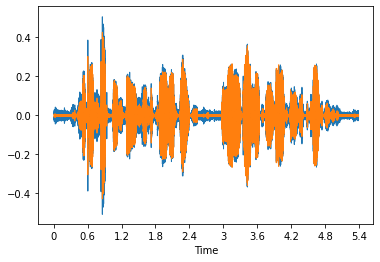

In [37]:
librosa.display.waveshow(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveshow(np.squeeze(predict(noisy_sounds[4])))

In [40]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [41]:
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=16000)